# Fitting Parameters for Virus Model

Analysis of the virus model.

 We will fit each of these patients separately, obtaining different values of parameters.

**Fitting**

 There are 6 patients with one value to fit. So, there are 6 different fits.


 Influenza, SARS and SARS-CoV3 in Tellurium

## A simple target cell-limited model, T ==> E ==> I --> produce V:
 T - number of target cells
 E - number of exposed cells (virus replicating inside, not yet spreading virus)
 I - number of infected cells (active virus production)
 V - viral titre, in units of TCID50/ml of biofluid wash (for Influenza)

# The ODEs
 dT/dt = - beta*T*V
 dE/dt =   beta*T*V - kappa*E;
 dI/dt =   kappa * E - delta*I;
 dV/dt =   p*y(I) - c*y(V);

 All viral data is in log10(load),...
 log10(load predicted by model) may be needed for data fitting


Influenza.csv
 Influenza A data - 5 patients
 viral levels in log10(TCID50 / ml of nasal wash)
 time in days since volunteer exposure
 each line in the array is an individual volunteer



SARS_CoV2_sputum.csv and SARS_CoV2_nasal.csv
 SARS-CoV-2 data - 9 patients,
 for each patient - viral loads from lungs (sputum) and from nasal cavity (swab)
 viral levels in log10(RNA copies / ml sputum), ...
 respectively log10(RNA copies / nasal swab)
 time in days since symptoms onset
 corresponding lines in the two arrays belong to an individual patient



SARS.csv
 SARS data recorded from 12 patients;
 included them just for comparison, probably too few datapoints for model inference
virus_analysis.py [python] format: unix; [1,1]                                                                                                                                   
viral levels in log10(RNA copies / ml of nasopharingeal aspirate)
 time - only three samples per patient, at 5, 10 and 15 days post symptoms onset
"""

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SBstoat
from SBstoat.modelStudy import ModelStudy
%matplotlib inline

## Antimony Model

In [2]:
ANTIMONY_MODEL  = '''
    // Equations
    E1: T -> E ; beta*T*V ; // Target cells to exposed
    E2: E -> I ; kappa*E ;  // Exposed cells to infected
    E3: -> V ; p*I ;        // Virus production by infected cells
    E4: V -> ; c*V ;        // Virus clearance
    E5: I -> ; delta*I      // Death of infected cells    

    // Parameters - from the Influenza article,
        
    beta = 3.2e-5;  // rate of transition of target(T) to exposed(E) cells, in units of 1/[V] * 1/day
    kappa = 4.0;    // rate of transition from exposed(E) to infected(I) cells, in units of 1/day
    delta = 5.2;    // rate of death of infected cells(I), in units of 1/day
    p = 4.6e-2;     // rate virus(V) producion by infected cells(I), in units of [V]/day
    c = 5.2;        // rate of virus clearance, in units of 1/day

    // Initial conditions
    T = 4E+8 // estimate of the total number of susceptible epithelial cells
             // in upper respiratory tract)
    E = 0
    I = 0
    V = 0.75 // the dose of virus in TCID50 in Influenza experiment; could be V=0 and I = 20 instead for a natural infection

'''

## Data Setup

In [3]:
"""
Transform the input data
"""

DIR = "/home/ubuntu/SBstoat/examples/virus"
INPUT_FILE =  os.path.join(DIR, "Influenza.csv")
NUM_BOOTSTRAP_ITERATIONS = 10000
VIRUS = "V"


# Convert input file to correct format
dataDF = pd.read_csv(INPUT_FILE, header=None)
dataDF = dataDF.transpose()
dataDF.index.name = "time"
patientDct = {p: "P%d" % (p+1) for p in range(6)}
dataDF = dataDF.rename(columns=patientDct)
observedTS = SBstoat.NamedTimeseries(dataframe=dataDF)

# Create separate data sources
dataSources = []
for colname in observedTS.colnames:
    newTS = observedTS.subsetColumns([colname])
    newTS[VIRUS] = newTS[colname]
    newTS = newTS.subsetColumns([VIRUS])
    dataSources.append(newTS)


## Model Study

Bootstrapping for instance src_1
Bootstrapping for instance src_2
Bootstrapping for instance src_3
Bootstrapping for instance src_4
Bootstrapping for instance src_5
Bootstrapping for instance src_6


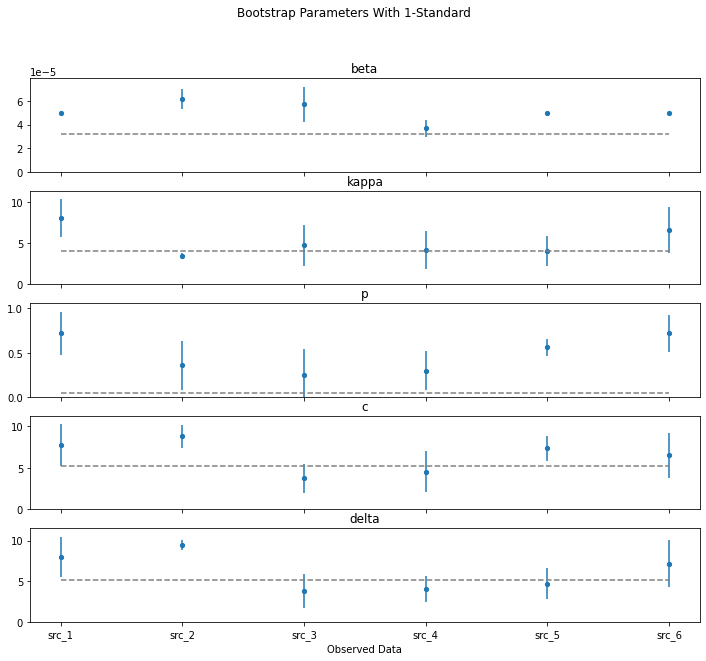

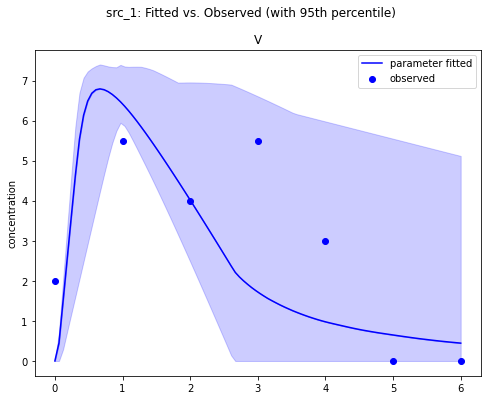

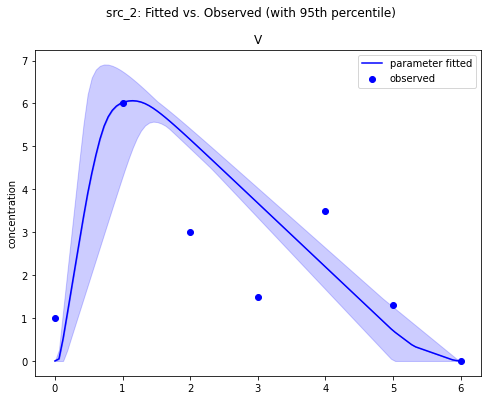

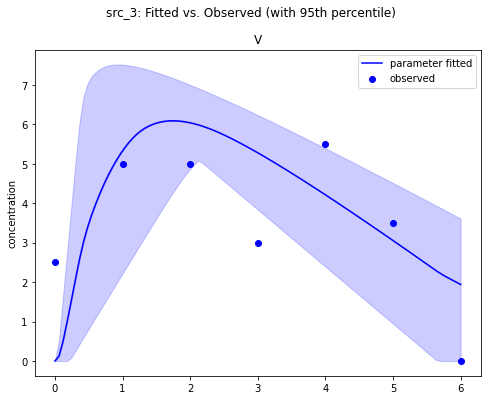

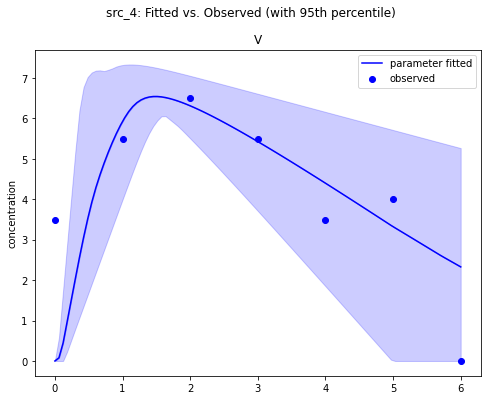

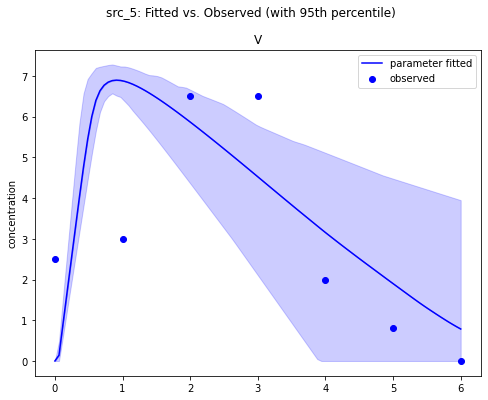

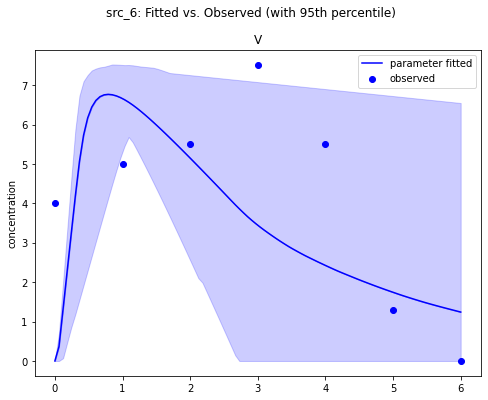

In [4]:
# Transformation of fitted values to match observed values
def transformDataArr(timeseries):
    """
    Changes the timeseries to log units
    """
    arr = np.array([1 if v < 1 else v
          for v in timeseries[VIRUS]])
    return np.log10(arr)


# Parameter value ranges: lower, upper, initial value
parameterDct = dict(
      beta=(0, 10e-5, 3.2e-5),
      kappa=(0, 10, 4.0),
      delta=(0, 10, 5.2),
      p=(0, 1, 4.6e-2),
      c=(0, 10, 5.2)
      )

dirPath = "/home/ubuntu/SBstoat/examples/virus/ModelStudyFitters"

# Study of model fitting
study = ModelStudy(ANTIMONY_MODEL, dataSources,
                  parameterDct=parameterDct,
                  dirPath=dirPath,
                  fittedDataTransformDct={"V": transformDataArr},
                  isSerialized=True)

study.bootstrap(numIteration=10)
study.plotParameterEstimates()
study.plotFitAll()
